# HW3 - Problem 1

#### Name: Alireza Maleki
#### Student Id: 401210956

In [109]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pathlib
from keras import callbacks
import datetime
from tensorflow.keras.metrics import Recall
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
import imageio
import matplotlib.pyplot as plt
import warnings
from sklearn.utils import shuffle

In [ ]:
cd '/path/to/dataset'

In [111]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [112]:
# loading data

boot_data_paths = pathlib.Path('./Boot').glob('*.jpg')
sandal_data_paths = pathlib.Path('./Sandal').glob('*.jpg')
shoe_data_paths = pathlib.Path('./Shoe').glob('*.jpg')
boot_data = [str(x) for x in boot_data_paths]
sandal_data = [str(x) for x in sandal_data_paths]
shoe_data = [str(x) for x in shoe_data_paths]

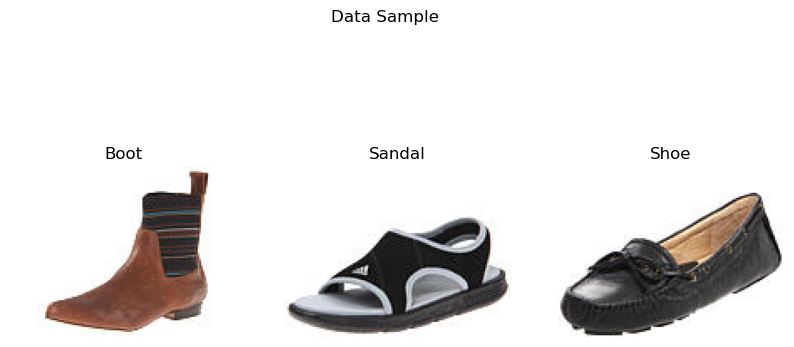

In [113]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
fig.suptitle("Data Sample")
warnings.filterwarnings("ignore")

## Boot
ax[0].imshow(imageio.imread(boot_data[0]))
ax[0].axis("off")
ax[0].set_title("Boot")
## Sandal
ax[1].imshow(imageio.imread(sandal_data[0]))
ax[1].axis("off")
ax[1].set_title("Sandal")
## Shoe
ax[2].imshow(imageio.imread(shoe_data[0]))
ax[2].axis("off")
ax[2].set_title("Shoe");

___

# MLP Model

We have to flatten data, and the input shape equals to $s[0] \times s[1] \times s[2]$

In [114]:
## data segregation

allLabel = []


dataShape = imageio.imread(boot_data[0]).shape
s = imageio.imread(boot_data[0]).reshape((-1,1)).shape[0]
sh = imageio.imread(boot_data[0]).shape
l = len(boot_data)+len(sandal_data)+len(shoe_data)

allData = np.zeros((l,s))
allLabel= np.zeros((l,3))

for i in range(len(boot_data)):
    allData[3*i,:] = imageio.imread(boot_data[i]).reshape((-1))
    allLabel[3*i,0] = 1
    
    newSandal = imageio.imread(sandal_data[i])
    if newSandal.shape != dataShape:   ### notice: some data has different shape. We have to adjust their shape
        reshapedData = np.zeros(dataShape)
        reshapedData[:newSandal.shape[0], :newSandal.shape[1], :newSandal.shape[2]] = newSandal
        newSandal = reshapedData
        
    allData[3*i+1,:] = newSandal.reshape((-1))
    allLabel[3*i+1,1] = 1
    allData[3*i+2,:] = imageio.imread(shoe_data[i]).reshape((-1))
    allLabel[3*i+2,2] = 1
    

s = allData[0].shape[0]
l = len(allData)
lt = int(l*.7)
allData, allLabel = shuffle(allData, allLabel)

m = np.mean(allData,1).reshape((-1,1))
st= np.std(allData,1).reshape((-1,1))


allData = (allData - m) / st / s

trainData, trainLabel = allData[:lt], allLabel[:lt]
testData, testLabel = allData[lt:], allLabel[lt:]

del allData, allLabel

In [115]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Activation, Conv2D, BatchNormalization, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical

model = models.Sequential()
model.add(Dense(200, input_dim=s, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 200)               8323400   
                                                                 
 dense_49 (Dense)            (None, 200)               40200     
                                                                 
 dense_50 (Dense)            (None, 100)               20100     
                                                                 
 dense_51 (Dense)            (None, 100)               10100     
                                                                 
 dense_52 (Dense)            (None, 100)               10100     
                                                                 
 dense_53 (Dense)            (None, 20)                2020      
                                                                 
 dense_54 (Dense)            (None, 3)                

In [116]:
rm -rf './logs/'

### Train Model

In [117]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Stop training when a monitored metric has stopped improving.
earlyStop = callbacks.EarlyStopping( patience=4, verbose=1, restore_best_weights=True, min_delta=1e-4)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy',
             metrics=['accuracy'])
with tf.device("/cpu:0"):
  model.fit(trainData, trainLabel, validation_split=0.25, batch_size=16, 
            epochs=10, callbacks=[tensorboard_callback, earlyStop])

Epoch 1/10
493/493 [==============================] - 4s 8ms/step - loss: 0.7499 - accuracy: 0.5916 - val_loss: 0.6764 - val_accuracy: 0.6693
Epoch 2/10
493/493 [==============================] - 4s 8ms/step - loss: 0.4231 - accuracy: 0.8300 - val_loss: 0.3672 - val_accuracy: 0.8602
Epoch 3/10
493/493 [==============================] - 4s 8ms/step - loss: 0.2940 - accuracy: 0.8928 - val_loss: 0.2777 - val_accuracy: 0.8960
Epoch 4/10
493/493 [==============================] - 4s 8ms/step - loss: 0.2613 - accuracy: 0.9076 - val_loss: 0.2638 - val_accuracy: 0.9051
Epoch 5/10
493/493 [==============================] - 4s 8ms/step - loss: 0.2388 - accuracy: 0.9148 - val_loss: 0.4427 - val_accuracy: 0.8309
Epoch 6/10
493/493 [==============================] - 4s 8ms/step - loss: 0.2255 - accuracy: 0.9183 - val_loss: 0.2904 - val_accuracy: 0.8960
Epoch 7/10
493/493 [==============================] - 4s 8ms/step - loss: 0.2069 - accuracy: 0.9269 - val_loss: 0.3182 - val_accuracy: 0.8891
Epoch 

### Test data evaluation

141/141 [==============================] - 0s 3ms/step
************************
Recall:  0.9188 ,        precision: 0.9203
************************


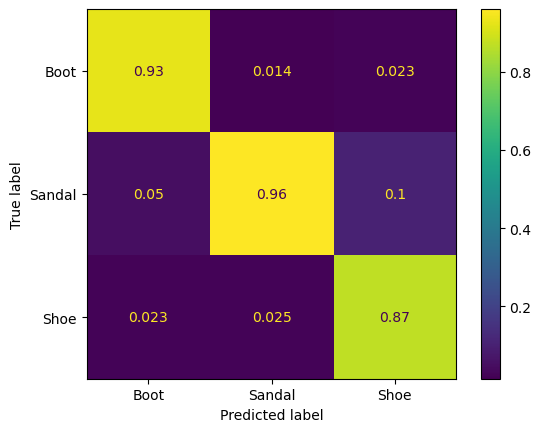

In [118]:
y_pred = model.predict(testData)

precision = precision_score(np.argmax(testLabel,1), np.argmax(y_pred,1), average='macro');
recall = recall_score(np.argmax(testLabel,1), np.argmax(y_pred,1), average='macro');

print('************************')
print("Recall: ", round(recall,4), ",        precision:", round(precision,4))
print('************************')

result = confusion_matrix(np.argmax(testLabel,1), np.argmax(y_pred,1), normalize="pred")

cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ['Boot', 'Sandal', 'Shoe'])
cm_display.plot()
plt.show()

In [119]:
%tensorboard --logdir logs/fit

___

# CNN Model

Here we use the orginal shape of data

In [120]:
allData = np.zeros((l,sh[0],sh[1],sh[2]))
allLabel= np.zeros((l), dtype=int)

for i in range(len(boot_data)):
    allData[3*i] = imageio.imread(boot_data[i])
    allLabel[3*i] = 0
    
    newSandal = imageio.imread(sandal_data[i])
    if newSandal.shape != dataShape:   ### notice: some data has different shape. We have to adjust their shape
        reshapedData = np.zeros(dataShape)
        reshapedData[:newSandal.shape[0], :newSandal.shape[1], :newSandal.shape[2]] = newSandal
        newSandal = reshapedData
        
    allData[3*i+1] = newSandal
    allLabel[3*i+1] = 1
    allData[3*i+2] = imageio.imread(shoe_data[i])
    allLabel[3*i+2] = 2

m = np.mean(allData,0)
st= np.std(allData,0)


allData = (allData /255) - .5

allData, allLabel = shuffle(allData, allLabel)

trainData, trainLabel = allData[:lt], allLabel[:lt]
testData, testLabel = allData[lt:], allLabel[lt:]

del allData, allLabel, shoe_data, sandal_data, boot_data

In [121]:
model = models.Sequential()
model.add(Conv2D(40,16, activation='relu', input_shape=sh))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Conv2D(40,16, activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(5,4, strides=3, activation='relu'))
model.add(Flatten())
model.add(Dense(20))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 87, 121, 40)       30760     
                                                                 
 batch_normalization_3 (Batc  (None, 87, 121, 40)      160       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 43, 60, 40)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 28, 45, 40)        409640    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 22, 40)       0         
 2D)                                                             
                                                     

In [122]:
rm -rf './logs/'

In [123]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
with tf.device("/cpu:0"):
  model.fit(trainData, to_categorical(trainLabel), validation_split=0.25, batch_size=32, 
            epochs=10, callbacks=[tensorboard_callback, earlyStop])

Epoch 1/10
247/247 [==============================] - 1156s 5s/step - loss: 0.7214 - accuracy: 0.7266 - val_loss: 0.5678 - val_accuracy: 0.8011
Epoch 2/10
247/247 [==============================] - 306s 1s/step - loss: 0.4679 - accuracy: 0.8201 - val_loss: 0.3862 - val_accuracy: 0.8632
Epoch 3/10
247/247 [==============================] - 336s 1s/step - loss: 0.3942 - accuracy: 0.8560 - val_loss: 0.3690 - val_accuracy: 0.8773
Epoch 4/10
247/247 [==============================] - 254s 1s/step - loss: 0.3532 - accuracy: 0.8738 - val_loss: 0.5006 - val_accuracy: 0.8442
Epoch 5/10
247/247 [==============================] - 254s 1s/step - loss: 0.3478 - accuracy: 0.8781 - val_loss: 0.3042 - val_accuracy: 0.8960
Epoch 6/10
247/247 [==============================] - 592s 2s/step - loss: 0.2790 - accuracy: 0.9025 - val_loss: 0.2969 - val_accuracy: 0.8971
Epoch 7/10
247/247 [==============================] - 281s 1s/step - loss: 0.2475 - accuracy: 0.9123 - val_loss: 0.3033 - val_accuracy: 0.909

141/141 [==============================] - 24s 170ms/step
************************
Recall:  0.9163 ,        precision: 0.9158
************************


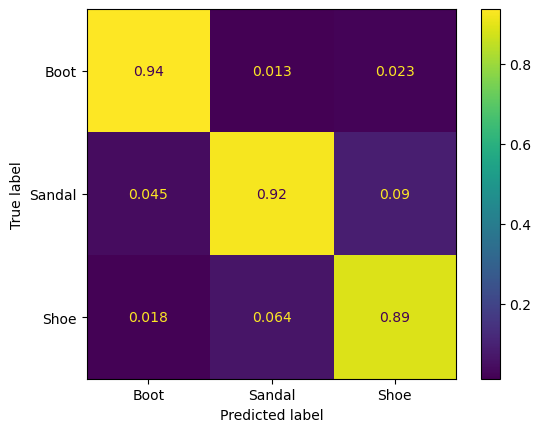

In [125]:
y_pred = model.predict(testData)
result = confusion_matrix(testLabel, np.argmax(y_pred,1), normalize="pred")

precision = precision_score(testLabel, np.argmax(y_pred,1), average='macro');
recall = recall_score(testLabel, np.argmax(y_pred,1), average='macro');

print('************************')
print("Recall: ", round(recall,4), ",        precision:", round(precision,4))
print('************************')

cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ['Boot', 'Sandal', 'Shoe'])
cm_display.plot()
plt.show()

In [126]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 51506), started 1:26:04 ago. (Use '!kill 51506' to kill it.)

___
# Factorization

In [127]:
model = models.Sequential()
model.add(Conv2D(40,(16,1), activation='relu', input_shape=sh))
model.add(Conv2D(40,(1,16), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2))
model.add(Conv2D(40,(16,1), activation='relu'))
model.add(Conv2D(40,(1,16), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(5,(4,1), strides=3, activation='relu'))
model.add(Conv2D(5,(1,4), strides=3, activation='relu'))
model.add(Flatten())
model.add(Dense(20))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 87, 136, 40)       1960      
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 121, 40)       25640     
                                                                 
 batch_normalization_4 (Batc  (None, 87, 121, 40)      160       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 43, 60, 40)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 60, 40)        25640     
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 45, 40)      

In [128]:
rm -rf './logs/'

In [129]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Recall()])
with tf.device("/cpu:0"):
  model.fit(trainData, to_categorical(trainLabel), validation_split=0.25, batch_size=32, 
            epochs=10, callbacks=[tensorboard_callback, earlyStop])

Epoch 1/10
247/247 [==============================] - 88s 356ms/step - loss: 0.4154 - accuracy: 0.8353 - recall_1: 0.7985 - val_loss: 0.5317 - val_accuracy: 0.8103 - val_recall_1: 0.7429
Epoch 2/10
247/247 [==============================] - 87s 351ms/step - loss: 0.2458 - accuracy: 0.9096 - recall_1: 0.9007 - val_loss: 0.2526 - val_accuracy: 0.9070 - val_recall_1: 0.8987
Epoch 3/10
247/247 [==============================] - 87s 352ms/step - loss: 0.1781 - accuracy: 0.9370 - recall_1: 0.9321 - val_loss: 0.2824 - val_accuracy: 0.8983 - val_recall_1: 0.8926
Epoch 4/10
247/247 [==============================] - 86s 350ms/step - loss: 0.1290 - accuracy: 0.9549 - recall_1: 0.9516 - val_loss: 0.1641 - val_accuracy: 0.9493 - val_recall_1: 0.9467
Epoch 5/10
247/247 [==============================] - 86s 350ms/step - loss: 0.1111 - accuracy: 0.9630 - recall_1: 0.9604 - val_loss: 0.1970 - val_accuracy: 0.9272 - val_recall_1: 0.9234
Epoch 6/10
247/247 [==============================] - 86s 350ms/s

141/141 [==============================] - 11s 79ms/step
************************
Recall:  0.9417 ,        precision: 0.9417
************************


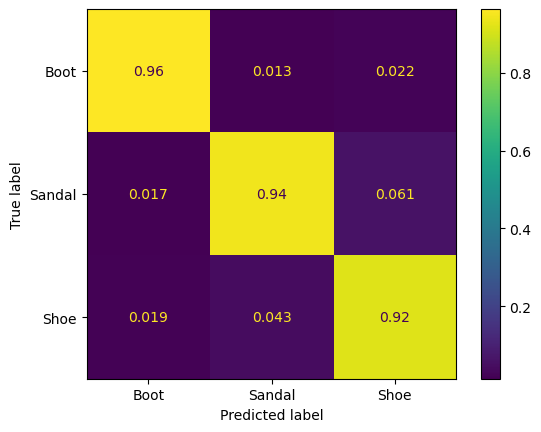

In [131]:
y_pred = model.predict(testData)

precision = precision_score(testLabel, np.argmax(y_pred,1), average='macro');
recall = recall_score(testLabel, np.argmax(y_pred,1), average='macro');

print('************************')
print("Recall: ", round(recall,4), ",        precision:", round(precision,4))
print('************************')

result = confusion_matrix(testLabel, np.argmax(y_pred,1), normalize="pred")

cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ['Boot', 'Sandal', 'Shoe'])
cm_display.plot()
plt.show()

___

As we can see, total number of params in the simple version is 446,568 and with the factorization it reduce to 80,353.

Because of this the model dimension reduced a lot. But its shattering ability stays near the origin model. So, the accuracy can increase and the training time bacome lower.